In [0]:
%tensorflow_version 2.x
import os, glob, math, json
import numpy as np
import pandas as pd

from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D

from PIL import Image
from datetime import datetime
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
drive.mount(os.path.join('/content', 'drive'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
PROJECT_PATH = os.path.join('/content', 'drive', 'My Drive',
                             'Hacktiv8', 'projData')

In [50]:
import tensorflow as tf
import os

## Just to ensure that we are working with TF v2.1.
if not (tf.__version__).startswith('2.1'):
    !pip install -q -U tensorflow
else: print (f"TF v: {tf.__version__}")


## Caching dataset on local drive instead of mounted drive to reduce
## buffering and speed up processing.
if not os.path.exists(os.path.join('cats_dogs', 'train')):
    !wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
    !unzip -q cats_and_dogs_filtered.zip
    !mv cats_and_dogs_filtered cats_dogs
    !ls cats_dogs | head

TF v: 2.1.0



# 0. Data Pre-analysis
We first need to check whether the data are consistent, in terms of image dimension.

In [0]:
train_width, train_height = [], []
train_channel = set()
test_width, test_height = [], []
test_channel = set()

In [0]:
for animal in ['dogs', 'cats']:
    animaux = animal[:-1]
    for fname in glob.glob(os.path.join('cats_dogs', 'train', animal, f'{animaux}*.jpg')):
        im = Image.open(fname)
        w, h = im.size
        train_width.append(w)
        train_height.append(h)
        train_channel.add(im.getbands())
    for fname in glob.glob(os.path.join('cats_dogs', 'validation', animal, f'{animaux}*.jpg')):
        im = Image.open(fname)
        w, h = im.size
        test_width.append(w)
        test_height.append(h)
        test_channel.add(im.getbands())

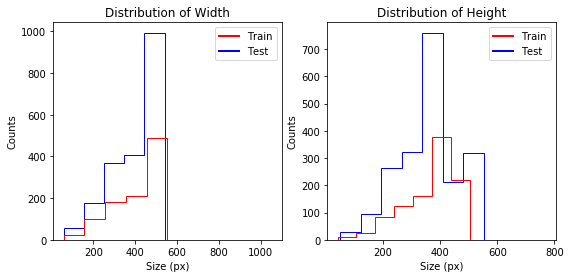

In [53]:
fig = plt.figure(figsize=(9, 4))
from matplotlib.lines import Line2D
custom_lines = [Line2D([1], [1], color='red', lw=2),
                Line2D([1], [1], color='blue', lw=2)]
plt.subplot(1, 2, 1)
plt.title('Distribution of Width')
plt.xlabel('Size (px)')
plt.ylabel('Counts')
plt.hist(train_width, label='trainWidth', color='blue', histtype='step')
plt.hist(test_width, label='testWidth', color='red', histtype='step')
plt.legend(custom_lines, ['Train', 'Test'])
plt.subplot(1, 2, 2)
plt.title('Distribution of Height')
plt.xlabel('Size (px)')
plt.ylabel('Counts')
plt.hist(train_height, label='trainHeight', color='blue', histtype='step')
plt.hist(test_height, label='testHeight', color='red', histtype='step')
plt.legend(custom_lines, ['Train', 'Test'])
plt.show()

In [54]:
df_dist = pd.DataFrame(index=['MedianWidth', 'MedianHeight'])
df_dist['Train'] = pd.Series({'MedianWidth': np.median(train_width),
                              'MedianHeight': np.median(train_height)})
df_dist['Test'] = pd.Series({'MedianWidth': np.median(test_width),
                              'MedianHeight': np.median(test_height)})
df_dist['Average'] = df_dist.mean(axis=1)
df_dist = df_dist.astype(int)
display (df_dist)

,Train,Test,Average
MedianWidth,442,448,445
MedianHeight,374,374,374


In [55]:
train_channel, test_channel

({('R', 'G', 'B')}, {('R', 'G', 'B')})



# 1. Model Initialisation & Training

We know that the colour channels are concordant between the datasets, i.e. RGB, so we can hardcode it appropriately during data loading. Also, due to the distribution of the dataset dimensions, let's take and rescale to the average of the median values.


In [56]:
BATCH_SIZE = 32
AVG_MED_WIDTH = 192#int(df_dist.loc['MedianWidth', 'Average']/4)
AVG_MED_HEIGHT = 192#int(df_dist.loc['MedianHeight', 'Average']/4)
print (f'AVG MED WIDTH {AVG_MED_WIDTH}')
print (f'AVG MED HEIGHT {AVG_MED_HEIGHT}')
INPUT_SIZE = (AVG_MED_HEIGHT, AVG_MED_WIDTH)

AVG MED WIDTH 192
AVG MED HEIGHT 192


Unfortunately, using the dimensions as stipulated by the median dimensions would quickly result in OOMError, so the dimensions were lowered.

Training images were augmented: rotational shifts, zooming, x- and y-axes shifts, horizontal and vertical flipping. Test images were not augmented.

In [57]:
print ("Getting Training Data")
trainGenerator = ImageDataGenerator(
                rescale=1./255, 
                rotation_range=30,
                zoom_range=0.15,
                width_shift_range=0.15, 
                height_shift_range=0.15, 
                horizontal_flip=True,
                vertical_flip=True,
                )

print ("Subsampling Training Set")
train_data = trainGenerator.flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory=os.path.join('cats_dogs', 'train'),
                    target_size=INPUT_SIZE,
                    color_mode='rgb',
                    class_mode='binary',
                    classes=['cats', 'dogs'],
                    subset='training')

print ("Test Data")
test_data = ImageDataGenerator(
                rescale=1./255
                ).flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory=os.path.join('cats_dogs', 'validation'),
                    target_size=INPUT_SIZE,
                    color_mode='rgb',
                    class_mode='binary',
                    classes=['cats', 'dogs'])
                
num_train_data = train_data.n
num_test_data = test_data.n

Getting Training Data
Subsampling Training Set
Found 2000 images belonging to 2 classes.
Test Data
Found 1000 images belonging to 2 classes.


In [0]:
labelName = {0.:'catto', 1.:'doggo'}

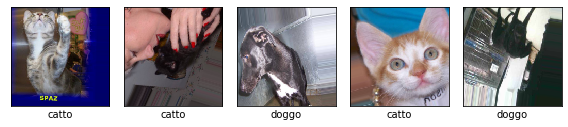

In [59]:
def plotImages(images_arr, label_arr):
    """
    Displays a selection of images (e.g. from training dataset)
    with their appropriate labels.
    Input: array_of_images[n], 
        where n takes the form of array slicer.
    Output: plot(s) of rescaled images with their curated annotation.
    """
    fig, axes = plt.subplots(1, 5, figsize=(8,8))
    axes = axes.flatten()
    for img, dataLabel, ax in zip(images_arr, label_arr, axes):
        ax.imshow(img)
        ax.set_xlabel(labelName[dataLabel])
        ax.set_yticks([])
        ax.set_xticks([])
    plt.tight_layout()
    plt.show()


sample_train, label = next(train_data)
plotImages(sample_train[:5], label[:5])

### Why this configuration?
We opted for a higher number of epochs and tandem it with early stopping and learning rate reduction (see next section) to maximise the training process. In this model, sequential convolution layers were constructed with increasing kernel size. To the best of our understanding, convolution simplifies the training data by doing mathematical operations that in turn may increase the  number of/enhance the features that can be obtained from the image source. However, we might not actually need all of those 'augmented' features, as such, a max pooling operation only extracts the most augmented feature for each area it iterates over. Additionally, to further reduce the complexity (and also speed up the training process), a small fraction of the convoluted and pooled dataset is dropped. Finally, all these features are flattened and a sigmoid activation function is applied, as the goal of this task is binary classification.

In [60]:
epochs = 128
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu',
                           input_shape=(AVG_MED_HEIGHT, AVG_MED_WIDTH, 3)),
    MaxPooling2D(3, strides=2),
    Dropout(0.2, seed=111),

    Conv2D(64, 3, padding='same', activation='relu'),    
    MaxPooling2D(2, strides=2),
    Dropout(0.2, seed=111),  

    Conv2D(128, 3, padding='same', activation='relu'),    
    MaxPooling2D(3, strides=2),
    Dropout(0.2, seed=111),  

    Conv2D(256, 3, padding='same', activation='relu'),   
    MaxPooling2D(2, strides=2),
    Dropout(0.2, seed=111), 

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.4, seed=111),
    Dense(1, activation='sigmoid')
    ])
model.compile(optimizer=optimizers.Adam(epsilon=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
model.summary()
now = datetime.strftime(datetime.today(), '%Y%m%d_%H%M')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 192, 192, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 95, 95, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 95, 95, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 47, 47, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 47, 47, 128)      

Callbacks were set up to halt training should the monitored metric, validation loss, stagnate. Learning rate would also be adjusted to a certain limit upon the plateauing of validation accuracy. This is done such that excessive training did not happen (and to conserve energy too) and at the same time maximises the validation accuracy.

In [0]:
early_stop = EarlyStopping(patience=15, verbose=1)

LR_reduce = ReduceLROnPlateau(monitor='val_accuracy', 
                            patience=12, 
                            verbose=1, 
                            factor=2/3, 
                            min_lr=1e-5)
callbacks = [early_stop, LR_reduce]

In [20]:
history = model.fit(train_data, 
                    steps_per_epoch=math.ceil(num_train_data/BATCH_SIZE), 
                    epochs=epochs,
                    validation_data=test_data,
                    callbacks=callbacks)
%time

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 63 steps, validate for 32 steps
Epoch 1/128
63/63 [==============================] - 25s 399ms/step - loss: 0.6964 - accuracy: 0.5105 - AUC: 0.5213 - Precision: 0.5076 - Recall: 0.6980 - val_loss: 0.6903 - val_accuracy: 0.5170 - val_AUC: 0.6082 - val_Precision: 0.9474 - val_Recall: 0.0360
Epoch 2/128
63/63 [==============================] - 24s 379ms/step - loss: 0.6793 - accuracy: 0.5625 - AUC: 0.5805 - Precision: 0.5723 - Recall: 0.4950 - val_loss: 0.6581 - val_accuracy: 0.6150 - val_AUC: 0.6767 - val_Precision: 0.7626 - val_Recall: 0.3340
Epoch 3/128
63/63 [==============================] - 24s 378ms/step - loss: 0.6626 - accuracy: 0.5900 - AUC: 0.6248 - Precision: 0.6216 - Recall: 0.4600 - val_loss: 0.6633 - val_accuracy: 0.6220 - val_AUC: 0.6844 - val_Precision: 0.7226 - val_Recall: 0.3960
Epoch 4/128
63/63 [==============================] - 24s 381ms/step - loss: 0.6343 - accuracy: 0.6305 - AUC: 0.6793 - Precision: 0.653

In [21]:
print ("Model Evaluation")
model.evaluate(test_data)

Model Evaluation
  ...
    to  
  ['...']
32/32 [==============================] - 3s 92ms/step - loss: 0.4282 - accuracy: 0.8330 - AUC: 0.9014 - Precision: 0.8208 - Recall: 0.8520


[0.4281740877777338, 0.833, 0.901376, 0.82080925, 0.852]

True

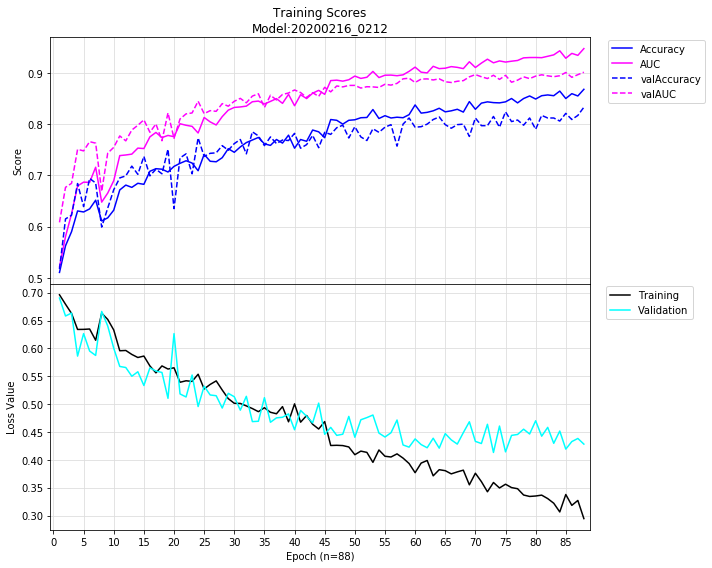

In [22]:
def plotHistory(history, plot=False):
    """
    Plots the evalation metrics of the trained model. Included metrics are
    accuracy, AUC, and loss in both training and validation data. Optionally,
    precision and recall metrics can also be plotted.
    Input: training history object
    Output: Two subplots showing the evaluation scores w.r.t. to the epoch.

    Note: any missing key (evaluation metric) from the history.history 
    dictionary will raise an exception and the plots would not be generated.
    The first missing key will be printed as the exception.
    """
    try:
        fig = plt.figure(figsize=(10, 8))
        plt.subplot(2, 1, 1)
        minVal, maxVal = 1, 0
        finalEpoch = len(history.history['accuracy'])
        for result in history.history:
            if 'loss' not in result:
                for val in history.history[result]:
                    if val < minVal: minVal = val
                    if val > maxVal: maxVal = val
        plt.title(f'Training Scores\nModel:{now}')
        plt.plot(range(1, finalEpoch+1), history.history['accuracy'], 
                 color='blue', label='Accuracy')
        plt.plot(range(1, finalEpoch+1), history.history['AUC'], 
                 color='magenta', label='AUC')
        plt.plot(range(1, finalEpoch+1), history.history['val_accuracy'], '--', 
                 color='blue', label='valAccuracy')
        plt.plot(range(1, finalEpoch+1), history.history['val_AUC'], '--', 
                 color='magenta', label='valAUC')
        plt.xticks(range(0, finalEpoch+1, 5))
        plt.xlim((-0.5, finalEpoch+1))
        plt.ylabel('Score')
        plt.grid(color='#DDDDDD')
        plt.tick_params(axis='x', labelcolor='#FFFFFF')
        plt.legend(bbox_to_anchor=(1.025, 1.01))
        plt.subplots_adjust(hspace=0.001)

        plt.subplot(2, 1, 2)
        plt.ylabel('Loss Value')
        plt.xlabel(f'Epoch (n={finalEpoch})')
        plt.xticks(range(0, finalEpoch+1, 5))
        plt.xlim((-0.5, finalEpoch+1))
        plt.plot(range(1, finalEpoch+1), history.history['loss'], 
                 color='black', label='Training')
        plt.plot(range(1, finalEpoch+1), history.history['val_loss'], 
                 color='cyan', label='Validation')
        plt.grid(color='#DDDDDD')
        plt.legend(bbox_to_anchor=(1.2, 1.01))
        
        
        if plot:
            plt.tight_layout()
            plt.subplots_adjust(hspace=0)
            plt.savefig(os.path.join(PROJECT_PATH, 
                                     f'{now}.png'))
        return True
    except Exception as E:
        print ('Unable to produce figure, missing key:', E) 
        return False

plotHistory(history, True)

In [23]:
def saveModel(history):
    """
    Collects all information about the training and the model and saved them
    into appropriate files: .h5 for the model and .json for the evaluation 
    statistics and training data augmentation parameters.
    Input: history object, image preprocessing generator object
    Output: h5 and json files

    Note: files are saved following the pattern YYYYMMDD_HHmm (in UTC timezone).
    """
    print ("Saving model configuration and training stats...")
    try:
        df = pd.DataFrame.from_dict(history.history)
        df.to_json(os.path.join(PROJECT_PATH, f'history_{now}.json'))
    except Exception as E:
        print ('Unable to save history!')
        pass
    with open(os.path.join(PROJECT_PATH, f'{now}.json'), 'wt') as inj:
        json.dump(history.model.to_json(), inj)
    with open(os.path.join(PROJECT_PATH, f'ImgDatGen_{now}.json'), 'wt') as inj:
        tempJson = json.dumps(vars(trainGenerator))
        json.dump(tempJson, inj)
    plt.show()
    model.save(os.path.join(PROJECT_PATH, f'model_{now}.h5'))
    print (f"Model saved as model_{now}.h5")
    return True

saveModel(history)

Saving model configuration and training stats...
Model saved as model_20200216_0212.h5


True

In [24]:
df_result = pd.DataFrame(index=['Training', 'Validation'],
                         columns=['Accuracy', 'AUC'],
                         data=[[history.history['accuracy'][-1], 
                                history.history['AUC'][-1]],
                               [history.history['val_accuracy'][-1],
                                history.history['val_AUC'][-1]]])

print ("Evaluation Statistics of the Model Trained Above")
df_result

Evaluation Statistics of the Model Trained Above


,Accuracy,AUC
Training,0.868,0.947494
Validation,0.833,0.901376


# 2. Model Testing
We have constructed and trained multiple models with different sets of parameters for image pre-processing and neural network architecture. In this section, they are listed and the user is allowed to use any listed model to their liking.

**Note that the model selected below MAY NOT be the same model as trained above. Multiple iteration of trainings were conducted and testing was done on the best model obtained.**

In [0]:
import re
import urllib.request as req
from tensorflow.keras.models import load_model

In [64]:
listOfModels = glob.glob(os.path.join(PROJECT_PATH, 'history*'))
for z, mod in enumerate(listOfModels):
    with open(mod, 'rt') as injs:
        data = json.load(injs)
        metricDict = [x for x in data if re.search('acc|auc|AUC', x)]
        nEpoch = len(data[list(metricDict)[0]])
        if data['val_accuracy'][str(nEpoch-1)] < 0.8: continue
        print (f"MODEL [{z}]: {os.path.basename(mod)}")
        print ("∆Accuracy [%] (Training-Validation):", 
               100*(data['accuracy'][str(nEpoch-1)] - 
               data['val_accuracy'][str(nEpoch-1)]))
        for metric in metricDict:
            print (f'{metric}: {data[metric][str(nEpoch-1)]}')
    print ()

while True:
    option = int(input("Which model would you like to use [int]? "))
    try:
        if option <= len(listOfModels):
            modelName = listOfModels[option]
            model = load_model(modelName
                                .replace('history', 'model')
                                .replace('.json', '.h5'))
            print (f"Model {modelName} selected.")
            break
    except Exception as E:
        print ("Selection is in integers only!", E)
        continue

MODEL [0]: history_20200214_1320.json
∆Accuracy [%] (Training-Validation): 1.8499970399999954
accuracy: 0.8424999714
AUC: 0.9156889915
val_accuracy: 0.824000001
val_AUC: 0.8882880211

MODEL [1]: history_20200214_1346.json
∆Accuracy [%] (Training-Validation): 2.3999989
accuracy: 0.8299999833
AUC: 0.9148819447
val_accuracy: 0.8059999943
val_AUC: 0.8948739767

MODEL [3]: history_20200214_1603.json
∆Accuracy [%] (Training-Validation): 0.9000003299999948
accuracy: 0.8389999866
AUC: 0.9250485301
val_accuracy: 0.8299999833
val_AUC: 0.9119580388

MODEL [4]: history_20200214_1738.json
∆Accuracy [%] (Training-Validation): 8.799999950000004
accuracy: 0.9210000038
AUC: 0.9783479571
val_accuracy: 0.8330000043
val_AUC: 0.9239620566

MODEL [5]: history_20200214_1925.json
∆Accuracy [%] (Training-Validation): 7.199996710000001
accuracy: 0.8899999857
AUC: 0.9597579837
val_accuracy: 0.8180000186
val_AUC: 0.891825974

MODEL [6]: history_20200215_0302.json
∆Accuracy [%] (Training-Validation): 2.39999891000

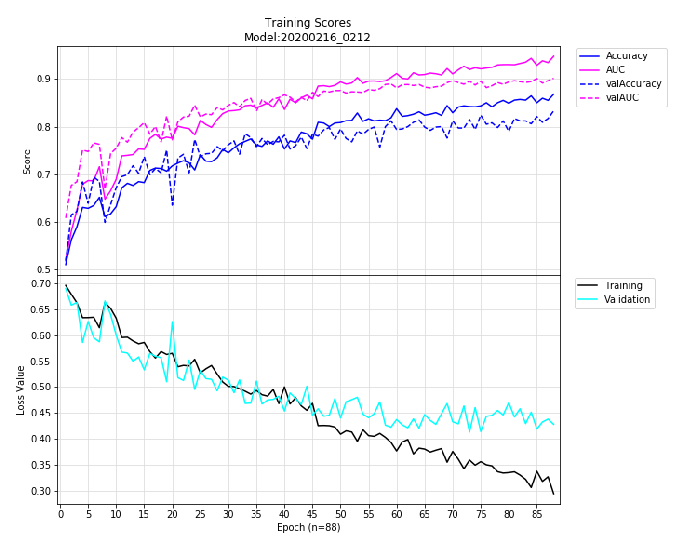

In [65]:
im = Image.open(modelName.replace('history_', '').replace('json', 'png'))
plt.figure(figsize=(12, 15), frameon=False)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.imshow(im)

In [66]:
print ("Training Image Augmentation Parameters")
with open(modelName.replace('history', 'ImgDatGen').replace('h5', 'json'), 
          'rt') as injs:
    data = json.load(injs)
    data = json.loads(data)

    display (pd.DataFrame.from_dict(data, orient='index'))

Training Image Augmentation Parameters


,0
featurewise_center,False
samplewise_center,False
featurewise_std_normalization,False
samplewise_std_normalization,False
zca_whitening,False
zca_epsilon,1e-06
rotation_range,30
width_shift_range,0.15
height_shift_range,0.15
shear_range,0


In [67]:
print ("Architecture of Selected Model")
print (model.summary())

Architecture of Selected Model
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 192, 192, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 95, 95, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 95, 95, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 47, 47, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)     

In [68]:
print ("Model Optimizer")
display(pd.DataFrame.from_dict(model.optimizer.get_config(), orient='index'))

Model Optimizer


,0
name,Adam
learning_rate,0.000444444
decay,0
beta_1,0.9
beta_2,0.999
epsilon,0.001
amsgrad,False


In [69]:
print ("Evaluation of Model")
model.evaluate(test_data)

Evaluation of Model
  ...
    to  
  ['...']
32/32 [==============================] - 4s 125ms/step - loss: 0.4280 - accuracy: 0.8330 - AUC: 0.9014 - Precision: 0.8208 - Recall: 0.8520


[0.4280472290702164, 0.833, 0.901376, 0.82080925, 0.852]

In [0]:
def predictCatDog(pathToImage, model=model):
    """
    Takes in an image in the local drive and predicts whether the object in the
    picture is a dog or a cat. 
    Input: path to image in local drive, model is pre-selected from previous 
            section if it had not been chosen
    Output: the image will be shown with the predicted class as the image title.
    """
    from tensorflow.keras.preprocessing.image import load_img
    target_size = model.input_shape[1:3]
    imgToPredict = load_img(pathToImage, 
                              target_size=target_size)
    imgToPredict = np.asarray(imgToPredict)
    plt.imshow(imgToPredict)
    imgToPredict = np.expand_dims(imgToPredict, axis=0)
    
    prediction = labelName[model.predict_classes(imgToPredict)[0,0]]
    plt.axis('off')
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout()
    plt.title(f"Prediction: {prediction}")
    plt.show()
    return True

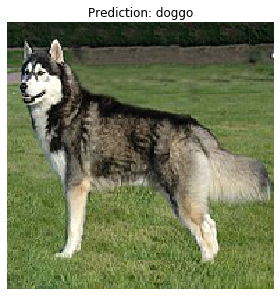

In [36]:
with open('temp.png', 'wb') as f:
    link = 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Black-Magic-Big-Boy.jpg/220px-Black-Magic-Big-Boy.jpg'
    f.write(req.urlopen(link).read())
    predictCatDog('temp.png')

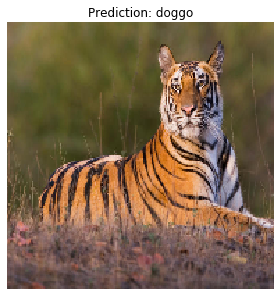

In [37]:
with open('temp.png', 'wb') as f:
    link = 'https://c402277.ssl.cf1.rackcdn.com/photos/18134/images/hero_small/Medium_WW226365.jpg?1574452099'
    f.write(req.urlopen(link).read())
    predictCatDog('temp.png')

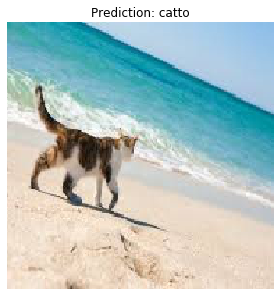

In [38]:
with open('temp.png', 'wb') as f:
    link = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRpIWoE-pL7ESUK_wZKxQV18HR0b9agMkkzqpOEtQx8c9M73pBV'
    f.write(req.urlopen(link).read())
    predictCatDog('temp.png')

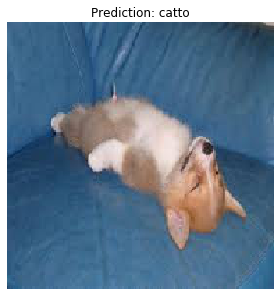

In [39]:
with open('temp.png', 'wb') as f:
    link = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSYrdxN4hcQ7ifM_LwoDAIzZraFEs9Zr7ge04_4COCrWEZBskjD'
    f.write(req.urlopen(link).read())
    predictCatDog('temp.png')

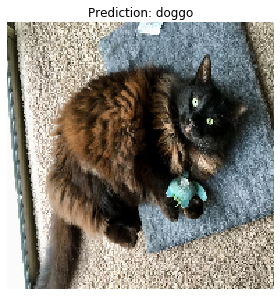

In [40]:
with open('temp.png', 'wb') as f:
    link = 'https://i0.wp.com/cdn-prod.medicalnewstoday.com/content/images/articles/327/327387/cat-playing-with-toy.jpg?w=1155&h=1734'
    f.write(req.urlopen(link).read())
    predictCatDog('temp.png')


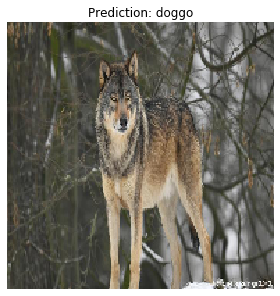

In [41]:
with open('temp.png', 'wb') as f:
    link = 'https://www.dw.com/image/45189092_303.jpg'
    f.write(req.urlopen(link).read())
    predictCatDog('temp.png')

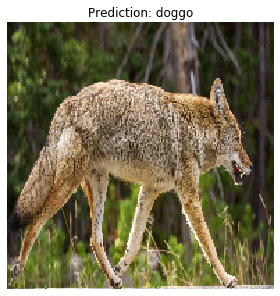

In [42]:
with open('temp.png', 'wb') as f:
    link = 'https://mediad.publicbroadcasting.net/p/shared/npr/styles/x_large/nprshared/202001/732668548.jpg'
    f.write(req.urlopen(link).read())
    predictCatDog('temp.png')

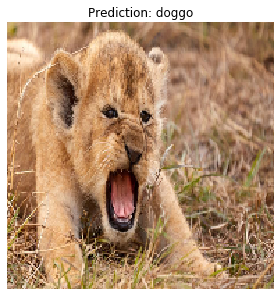

In [43]:
with open('temp.png', 'wb') as f:
    link = 'https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/12/931/524/lion-king-photo-2.jpg?ve=1&tl=1'
    f.write(req.urlopen(link).read())
    predictCatDog('temp.png')

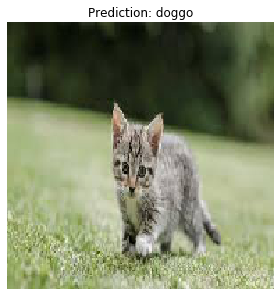

In [44]:
with open('temp.png', 'wb') as f:
    link = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQcq9w_H0nQ2QojkQem3vZDrR5BgLbpNGjd6NGsUhZ3N2l0gbLN'
    f.write(req.urlopen(link).read())
    predictCatDog('temp.png')

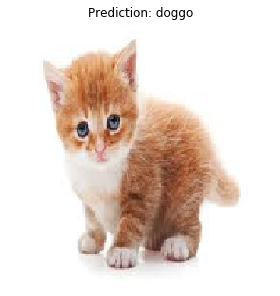

In [45]:
with open('temp.png', 'wb') as f:
    link = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRqiL67CsbWdeuQSk8JKSDKMIZMn77psvvdHu8sSJZgbHqXiRDh'
    f.write(req.urlopen(link).read())
    predictCatDog('temp.png')


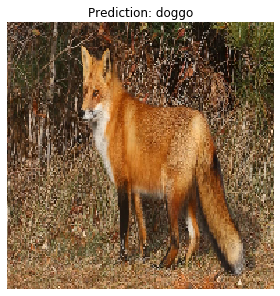

In [46]:
with open('temp.png', 'wb') as f:
    link = 'https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/02/1024/512/iStock-fox.jpg?ve=1&tl=1'
    f.write(req.urlopen(link).read())
    predictCatDog('temp.png')

# 3. Summary
The goal of this project was to develop a neural network-based classifier to distinguish whether an image contains a dog(s) or a cat(s). Our sequential model was composed of multiple convolutional layers of increasing kernel size with small dropout post-max pooling. Training was conducted on a small dataset containing 2000 images, with equal annotation distribution of cats and dogs. Image augmentations were done on the training set but not on the validation set. The best model achieved training and validation accuracy of 86.79% and 83.30%, and training and validation AUC of 0.947 and 0.901, respectively. We tested our model on human-annotated images that were collected from an online search engine and also several species that belong to the same taxonomical family as cats (lion, tiger) and dogs (wolf, coyote). The best model were not able to predict some test cases correctly, and considering the small overfitting (∆accuracy = 3.49%), we attribute its misclassifications to the moderate accuracy and AUC metrics. 


# 4. Self-reflection
This was quite a challenging task as it requires a very thorough thinking prior to training. It would be interesting to see how established, peer-reviewed models would have performed for this application. Additionally, I do wonder, is there anyway we could perhaps do a reverse image search on the training image and get the first few results' keywords as some sort of weight booster for better training? Should I expect different results had I used the deep learning framework from PyTorch, instead of TensorFlow?  
*Det är bara borjan. Sen ska vi se hur vi får förbättra.*